In [1]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math
import matplotlib.pyplot as plt
#%matplotlib
import seaborn as sns


import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim
import pickle 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sim = torch.load("REAL_SIM.pt")

In [3]:
#three regions with each region having 100 units and 1201 time series data
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0) #300 x 1201
activity = activity[:,:300]

Na = sim['params']['Na']
Nb = sim['params']['Nb']
Nc = sim['params']['Nc']

regions = []
regions.append(['Region A', np.arange(0, Na)])
regions.append(['Region B', np.arange(Na, Na + Nb)])
regions.append(['Region C', np.arange(Na + Nb, Na + Nb + Nc)])
regions = np.array(regions, dtype=object)

# Initializing the parameters 

In [4]:
dtData=sim['params']['dtData'] # time step of training data
# dtData=None
dtFactor=5 # number of interpolation steps for RNN 
regions=regions # number of regions and names of the regions
# tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
tauRNN=50 # decay constant of RNN 

g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
resetPoints=None
plotStatus=True
regions=None


In [5]:
if dtData is None: #0.01
    print('dtData not specified. Defaulting to 1.');
    dtData = 1;
if resetPoints is None:
    resetPoints = [0, ]
if regions is None:
    regions = {}

In [6]:
number_units = activity.shape[0] #300 -- the total number of units 
number_learn = activity.shape[0] #300
dtRNN = dtData / float(dtFactor) # 0.01/5=0.002

In [7]:
learnList = npr.permutation(number_units) #randomize the units
iTarget = learnList[:number_learn]
iNonTarget = learnList[number_learn:] # []

tData = dtData*np.arange(activity.shape[1]) #   [0, 0.01, 0.02 ....,12.01] #1201 input time steps 
tRNN = np.arange(0, tData[-1] + dtRNN, dtRNN) # [0, 0.002, 0.004 ...., 12.01] #6000 rnn time steps

# External Input to RNN

In [8]:
ampWN = math.sqrt(tauWN/dtRNN) # (0.1/0.002)
iWN = ampWN * npr.randn(number_units, len(tRNN)) #gaussian noise ? #300x6001
inputWN = np.ones((number_units, len(tRNN))) #300x6001
# print("inputWN : ",inputWN)
for tt in range(1, len(tRNN)):
    inputWN[:, tt] = iWN[:, tt] + (inputWN[:, tt - 1] - iWN[:, tt])*np.exp(- (dtRNN / tauWN)) # solve the above differential equation 
inputWN = ampInWN * inputWN # external input h(t)


# Set up target training data

In [9]:
Adata = activity.copy()
Adata = Adata/Adata.max()
Adata = np.minimum(Adata, 0.999) # elementwise minimum 
Adata = np.maximum(Adata, -0.999) # elementwise max
print (Adata.shape)

(300, 300)


# Model Definition

In [10]:
import sys 

class CTRNN(nn.Module):
    """Continuous-time RNN."""
    def __init__(self,
                 g,
                 tauRNN,
                 dtRNN,
                 input_units,
                 output_units,
                 dt=None,
                 interregion_sparsity=0.1, #Lower = more sparse, 1 to disable
                 intraregion_sparsity=0.1, # Lower = sparser, 1 to disble
                 **kwargs):
      
        super(CTRNN,self).__init__()

        self.tauRNN = tauRNN
        self.dtRNN=dtRNN
        self.g=g
        self.input_units=input_units
        self.output_units=output_units
        
        
#        print(self.J)
        mask = torch.ones(300,300)
        mask[:100, 100:300] = torch.rand_like(mask[:100, 100:300]) <= interregion_sparsity
        mask[100:200, 0:100] = torch.rand_like(mask[100:200, 0:100]) <= interregion_sparsity
        mask[100:200, 200:] = torch.rand_like(mask[100:200, 200:]) <= interregion_sparsity
        mask[200:,0:200] = torch.rand_like(mask[200:,0:200]) <= interregion_sparsity
        
        mask[:100, :100] = torch.rand_like(mask[:100, :100]) <= intraregion_sparsity
        mask[100:200, 100:200] = torch.rand_like(mask[:100, :100]) <= intraregion_sparsity
        mask[200:, 200:] = torch.rand_like(mask[:100, :100]) <= intraregion_sparsity
        
        self.mask = mask
        self.J = nn.Parameter((self.g * torch.Tensor(npr.randn(input_units, output_units) / math.sqrt(output_units)))  * self.mask )

        #print(torch.numel(mask[0:100, 100:]))
      
    def forward(self, hidden, noise=None):
        if(noise is not None):
           noise = torch.zeros_like(noise)
        
        """Propogate input through the network."""
        
        # When calculating fixed points: We want to find _hidden_ vectors such that -hidden + JR equals the 0 vector.
        activation = torch.tanh(torch.Tensor(hidden))
        JR = torch.matmul(self.J, activation).reshape((self.input_units,1))
        

        new_hidden = hidden + self.dtRNN*(-hidden + JR)/self.tauRNN
        return activation, new_hidden



In [11]:

g = 1.5
rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units)

rnn_model.to(device)
rnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))
rnn_model.load_state_dict(torch.load("intraregion_sparse_weights.pt"))
weights_initial = rnn_model.J.detach().cpu().numpy().copy()


# Validation

In [12]:
#checkpoint = torch.load("CTRNN_weights1.pt")
#rnn_model.load_state_dict(checkpoint)
#optimizer.load_state_dict(checkpoint['optimizer'])
#epoch = checkpoint['epoch']


def validate(model,tRNN):
    
    with torch.no_grad():
      hidden = torch.tanh(torch.Tensor(Adata[:, 0, np.newaxis])).to(device)
      tLearn = 0 
      iLearn = 0 
      predicted=[]
      gt=[]

      for i in range(1,len(tRNN)):
          tLearn += dtRNN
          
          output, hidden = rnn_model(hidden,
                                     torch.Tensor(inputWN[:, i, np.newaxis]).to(device))
          

          if tLearn >= dtData:
            tLearn=0
            predicted.append(torch.tensor(output).detach().cpu().numpy())
            gt.append(torch.Tensor(Adata[:, iLearn ,np.newaxis]).to(device).detach().cpu().numpy())
            iLearn = iLearn + 1 
            
                
    return predicted, gt

preds,actual = validate(rnn_model,tRNN=tRNN)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_21804\2054434804.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted.append(torch.tensor(output).detach().cpu().numpy())


# Plot the activity of a neuron 

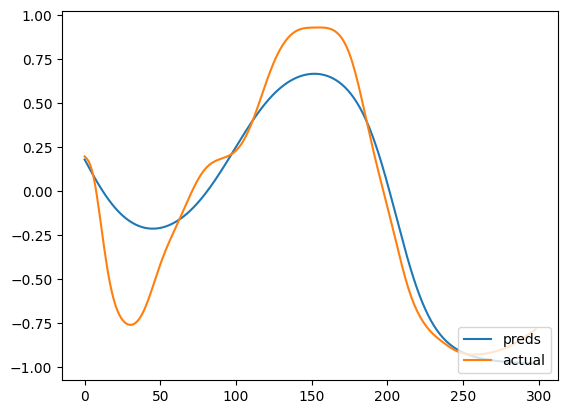

In [13]:
neuron_id = 1
x = list(range(len(preds)))
p=[pred[neuron_id][0] for pred in preds]
a=[act[neuron_id][0] for act in actual]


plt.plot(p)
plt.plot(a)
plt.legend(["preds", "actual"], loc ="lower right")
plt.show()

# Plot the average activity of regions

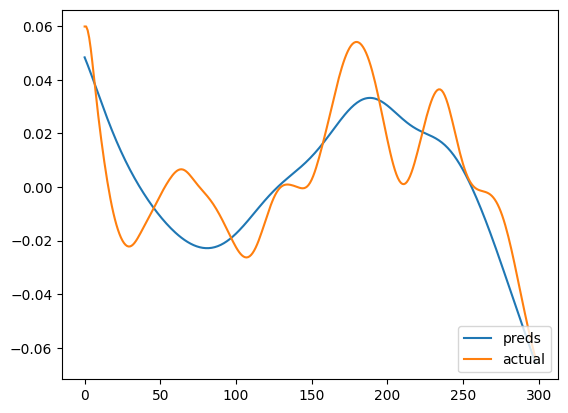

In [14]:
p_area=[pred[:100].mean() for pred in preds]
a_area=[act[:100].mean() for act in actual]


plt.plot(p_area)
plt.plot(a_area)
plt.legend(["preds", "actual"], loc ="lower right")
plt.show()

In [26]:
torch.min(rnn_model.J)

tensor(-14.2512, grad_fn=<MinBackward1>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


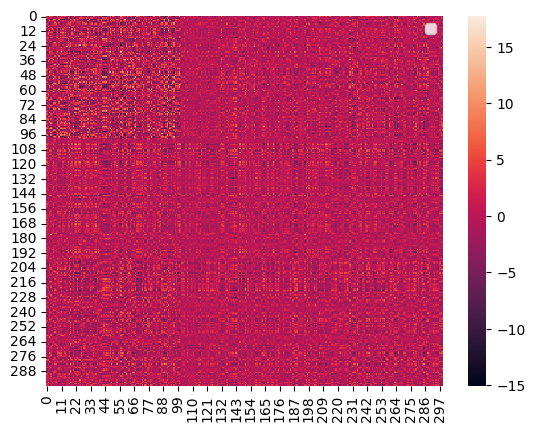

In [34]:
from glob import glob
import seaborn as sns
fig, ax =plt.subplots(1,1)

#rnn_model.load_state_dict(torch.load("interregion_sparse.pt"))
#rnn_model.load_state_dict(torch.load("intraregion_sparse_weights.pt"))
rnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))
'''
meta_file = glob(f'/content/drive/MyDrive/Colab Notebooks/CURBD/g_expt/{g_val}/meta*')[0]
meta_data = torch.load(meta_file)
loss_list = [i.item() for i in meta_data['loss_list']]
# plt.plot(loss_list, label=f'g val = {g_val}');
'''
intial_w = rnn_model.J.detach().numpy()
#final_w = meta_data['trained_weights']
s=sns.heatmap(intial_w)


#t=sns.heatmap(final_w[0:10,0:10], ax=ax[1][i])
#t.set_xlabel(f'g={g_val}', fontsize=10)
'''if i==0:
    s.set_ylabel(f'Initial DI Matrix', fontsize=10)
    t.set_ylabel(f'Trained DI Matrix', fontsize=10)'''

plt.legend()
plt.savefig("plots/weights/regular.png", transparent=True, dpi=500)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


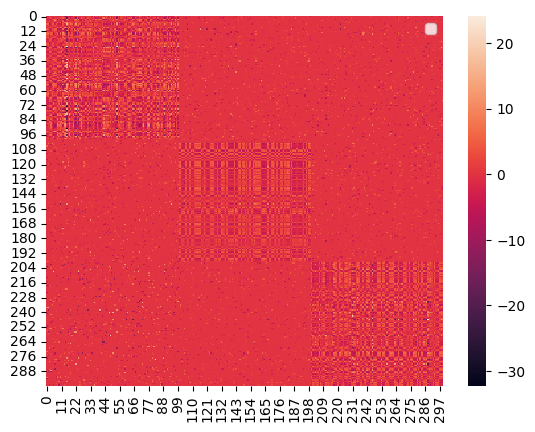

In [35]:
from glob import glob
import seaborn as sns
fig, ax =plt.subplots(1,1)

#rnn_model.load_state_dict(torch.load("interregion_sparse.pt"))
#rnn_model.load_state_dict(torch.load("intraregion_sparse_weights.pt"))
rnn_model.load_state_dict(torch.load("interregion_sparse.pt"))
'''
meta_file = glob(f'/content/drive/MyDrive/Colab Notebooks/CURBD/g_expt/{g_val}/meta*')[0]
meta_data = torch.load(meta_file)
loss_list = [i.item() for i in meta_data['loss_list']]
# plt.plot(loss_list, label=f'g val = {g_val}');
'''
intial_w = rnn_model.J.detach().numpy()
#final_w = meta_data['trained_weights']
s=sns.heatmap(intial_w)


#t=sns.heatmap(final_w[0:10,0:10], ax=ax[1][i])
#t.set_xlabel(f'g={g_val}', fontsize=10)
'''if i==0:
    s.set_ylabel(f'Initial DI Matrix', fontsize=10)
    t.set_ylabel(f'Trained DI Matrix', fontsize=10)'''

plt.legend()
plt.savefig("plots/weights/interregion_sparse.png", transparent=True, dpi=500)
plt.show()

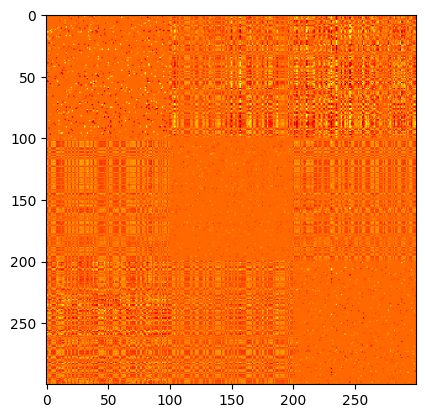

In [18]:
from glob import glob
import seaborn as sns
fig, ax =plt.subplots(1,1)

#rnn_model.load_state_dict(torch.load("interregion_sparse.pt"))
#rnn_model.load_state_dict(torch.load("intraregion_sparse_weights.pt"))
rnn_model.load_state_dict(torch.load("intraregion_sparse_weights.pt"))
'''
meta_file = glob(f'/content/drive/MyDrive/Colab Notebooks/CURBD/g_expt/{g_val}/meta*')[0]
meta_data = torch.load(meta_file)
loss_list = [i.item() for i in meta_data['loss_list']]
# plt.plot(loss_list, label=f'g val = {g_val}');
'''
intial_w = rnn_model.J.detach().numpy()
#final_w = meta_data['trained_weights']
s=sns.heatmap(intial_w)


#t=sns.heatmap(final_w[0:10,0:10], ax=ax[1][i])
#t.set_xlabel(f'g={g_val}', fontsize=10)
'''if i==0:
    s.set_ylabel(f'Initial DI Matrix', fontsize=10)
    t.set_ylabel(f'Trained DI Matrix', fontsize=10)'''

plt.legend()
plt.savefig("plots/weights/intraregion_sparse.png", transparent=True, dpi=500)
plt.show()